# Project Introduction

The specific task we are aiming to address in this project is image classification. We will utilize a Self-Driving Cars dataset containing 22,241 images, with 18,000 images allocated for training and 4,241 for testing, divided into 5 classes. The classes include:

* 1: Car
* 2: Truck
* 3: Pedestrian
* 4: Bicyclist
* 5: Light

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Import needed libraries

In [ ]:
# base libraries
import numpy as np
import pandas as pd
import pathlib

import math
import random
import warnings
from torch.utils.data import Dataset, random_split

# plotting libraries
import matplotlib.pyplot as plt
!pip install matplotlib pillow
import seaborn as sns
import graphviz
import matplotlib.image as mpimg

import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data

sns.set()
torch.manual_seed(0)

# essential object detection libraries
import os
import cv2
from IPython.display import display, Image  # Display an image in a Jupyter Notebook cell
from PIL import Image  # Open an image file
import json
from pandas.io.json import json_normalize
from collections.abc import Iterable

# For processing time
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split

In [ ]:
print(os.getcwd())

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## CSV file of the train and test set

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
TRAIN_PATH = DATA_DIR +"/Training_set.csv"
TEST_PATH = DATA_DIR +"/Testing_set.csv"

open(TRAIN_PATH)

open(TEST_PATH)

<_io.TextIOWrapper name='/content/drive/MyDrive/Colab Notebooks/Testing_set.csv' mode='r' encoding='UTF-8'>

### Head of the Data

In [ ]:
# Read CSV files into pandas DataFrames
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# Display the head of each DataFrame
print("Head of labels_train.csv:")
print(train_df.head())

print("\nHead of labels_val.csv:")
print(test_df.head())

Head of labels_train.csv:
                  filename  label
0  1478019952686311006.jpg      1
1  1478019952686311006.jpg      3
2  1478019953180167674.jpg      1
3  1478019953689774621.jpg      2
4  1478019953689774621.jpg      1

Head of labels_val.csv:
                  filename
0  1478899046136829030.jpg
1  1478899046136829030.jpg
2  1478899046136829030.jpg
3  1478899046136829030.jpg
4  1478899046136829030.jpg


### Unzip the images

In [ ]:
#import zipfile
#!unzip '/content/drive/MyDrive/Colab Notebooks/test3.zip' -d '/content/drive/MyDrive/Colab Notebooks/test3out3'

In [ ]:
class SelfDrivingCarsDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, train=True):
        df = pd.read_csv(csv_path)
        self.image_names = df["filename"]
        self.train = train
        if train:
            self.labels = df["label"]
            self.classes = list(set(self.labels))
        self.img_dir = img_dir
        self.transform = transform


    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.image_names[index]))
        if self.transform is not None:
          img = self.transform(img)
        if self.train:
            label = self.labels[index]
            return img, label
        else:
            return img
    def __len__(self):
        return self.labels.shape[0]

In [ ]:
from torch.utils.data import DataLoader

train_transform = transforms.Compose(
        [
            transforms.Resize(128),
            transforms.CenterCrop((64, 64)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
test_transform = transforms.Compose(
        [
            transforms.Resize(128),
            transforms.CenterCrop((64, 64)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )
train_dataset = SelfDrivingCarsDataset(
    csv_path= TRAIN_PATH,
    img_dir=r'/content/drive/MyDrive/Colab Notebooks/train',
    transform= train_transform
)

test_dataset = SelfDrivingCarsDataset(
    csv_path=TEST_PATH,
    img_dir=r'/content/drive/MyDrive/Colab Notebooks/test',
    transform=test_transform,
    train=False
)

## Exploratory Data Analysis

Number of Images in training: 132406
Number of Classes: 5
Label Statistics:
{'Number of Labels': 132406, 'Number of Unique Labels': 5, 'Label Value Counts': {1: 101314, 5: 12700, 3: 10637, 2: 6313, 4: 1442}}


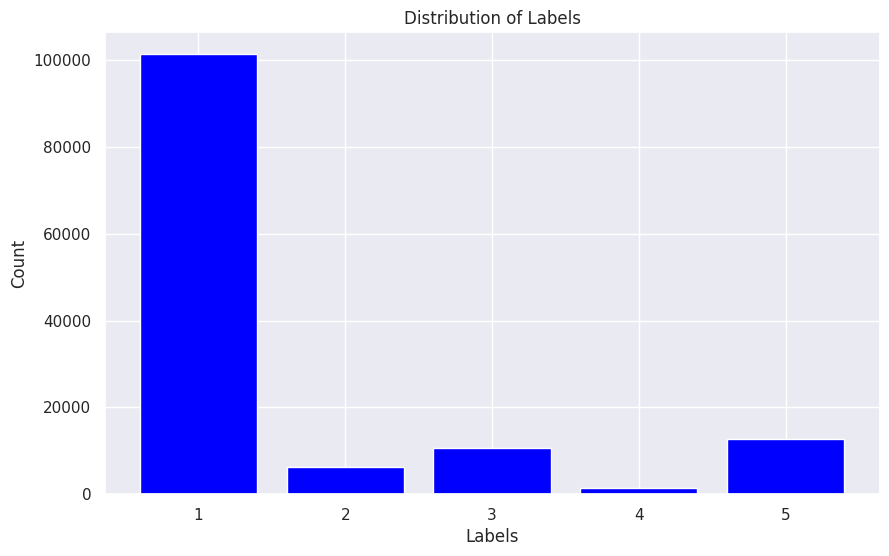

In [ ]:
# Number of images
num_images = len(train_dataset)

# Number of classes
num_classes = len(train_dataset.classes) if hasattr(train_dataset, 'classes') else None

# Basic statistics for labels (if applicable)
if hasattr(train_dataset, 'labels'):
    labels = train_dataset.labels
    label_stats = {
        "Number of Labels": len(labels),
        "Number of Unique Labels": len(labels.unique()),
        "Label Value Counts": labels.value_counts().to_dict(),
    }
else:
    label_stats = None
# Classic_id labels: '1: car', '2: truck', '3: pedestrian', '4: bicyclist', '5: light'
# Print the summary statistics
print(f"Number of Images in training: {num_images}")
print(f"Number of Classes: {num_classes}")
print("Label Statistics:")
print(label_stats)

# Visualize the output numbers in a bar plot
if label_stats:
    # Extract information for the bar plot
    unique_labels = list(label_stats["Label Value Counts"].keys())
    label_counts = list(label_stats["Label Value Counts"].values())

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, label_counts, color='blue')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

### Visualize Some Images in the Dataset

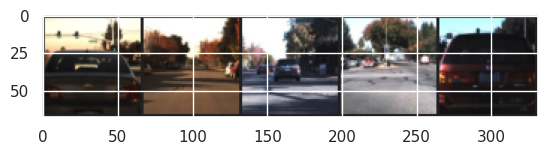

Labels: [1, 1, 1, 1, 1]


In [ ]:
def imshow(img):
    img = img * 0.3081 + 0.1307  # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of images you want to display
num_to_display = 5

# Randomly select indices
indices = random.sample(range(len(train_dataset)), num_to_display)

# Get images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a grid of images and show them
imshow(torchvision.utils.make_grid(images))

# Optionally, print the corresponding labels
print("Labels:", labels)

### Images Size

In [ ]:
# Get a list of all image files in the folder
folder_path = r'/content/drive/MyDrive/Colab Notebooks/train'

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]

# Check if there's at least one image
if image_files:
    first_image_path = os.path.join(folder_path, image_files[0])
    with Image.open(first_image_path) as img:
        width, height = img.size
        print(f"Size of the first image ({image_files[1200]}): {width}x{height}")
else:
    print("No image files found in the specified folder.")

Size of the first image (1479504762896684239.jpg): 480x300


## Convolutional Neural Networks 1

### Split Dataset into Train and Validation Sets

In [ ]:
val_ratio = 0.2
train_ratio = 1 - val_ratio
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=64,
    shuffle=True,  # want to shuffle the dataset
    num_workers=0,  # number processes/CPUs to use
)

In [ ]:
val_loader = DataLoader(
    dataset=val_subset,
    batch_size=64,
    shuffle=False,  # want to shuffle the dataset
    num_workers=0,  # number processes/CPUs to use
)

In [ ]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [ ]:
train_labels = [train_dataset[idx][1] for idx in train_subset.indices]

# Get labels on validation set
val_labels = [train_dataset[idx][1] for idx in val_subset.indices]

In [ ]:
len(train_labels)

105924

In [ ]:
train_dataset.labels.nunique()

5

In [ ]:
num_classes = len(set(train_labels))

### Define Model Architechture

#### Net A

In [ ]:
class NetA(nn.Module):

    def __init__(self):
        super(NetA, self).__init__()
        self.lin1 = nn.Linear(64*64*3, 10)  # 32*32 from image dimension
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(10, 5)

    def forward(self, x):
        x = x.view(-1, 64*64*3)  # flatten all dimensions except the batch dimension
        x = self.lin1(x) # Pass the image into a fully connected layer
        x = self.relu1(x) # Use a fully-connected linear layer with 300 hidden-neurons followed by a ReLU activation function
        x = self.lin2(x) # Use a fully-connected linear layer to the 10 outputs.
        return x

netA = NetA()
print(netA)

NetA(
  (lin1): Linear(in_features=12288, out_features=10, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=10, out_features=5, bias=True)
)


In [ ]:
modelA = NetA().to(device)
print(modelA)

NetA(
  (lin1): Linear(in_features=12288, out_features=10, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=10, out_features=5, bias=True)
)


#### Net B

In [ ]:
class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.lin1 = nn.Linear(64*64*3, 15)  # is it right though? we get a fully connected layer with 10 outputs
        self.relu1 = nn.ReLU() # Do Relu functions have to have index to distingush them? You don't need to define relu! But if you don't want to define it, you should call it from a library in torch, and call it with f.relu
        self.lin2 = nn.Linear(15, 20)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(20, 5)

    def forward(self, x):
        x = x.view(-1, 64*64*3) # flatten all dimensions except the batch dimension
        x = self.lin1(x) #Question: sometime we put f.relu, and sometime we put self.relu, how's that different?
        x = self.relu1(x)  # Use a fully-connected linear layer with 100 hidden-neurons followed by a ReLU activation function
        x = self.lin2(x)
        x = self.relu2(x)  # Use a fully-connected linear layer with 60 hidden-neurons followed by a ReLU activation function
        x = self.lin3(x) # Use a fully-connected linear layer to the 10 outputs.
        return x

netB = NetB()
print(netB)

NetB(
  (lin1): Linear(in_features=12288, out_features=15, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=15, out_features=20, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=20, out_features=5, bias=True)
)


In [ ]:
modelB = NetB().to(device)
print(modelB)

NetB(
  (lin1): Linear(in_features=12288, out_features=15, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=15, out_features=20, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=20, out_features=5, bias=True)
)


#### Net C

In [ ]:
class NetC(nn.Module):
    def __init__(self,):
        super(NetC, self).__init__()
        # 3 input image channel, 25 output channels, 5x5 square convolution kernel
        # Question: I'm not sure how it's going to implement the 25@64*64 convolution
        self.conv1 = nn.Conv2d(3, 25, 5)        # Output Image 25@60*60
        self.relu1 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)  # Output Image 25@30*30
        self.lin1 = nn.Linear(25 * 30 * 30, 5)

    def forward(self, x):
        # A convolution layer with a kernel width of 5 and a depth of 25 is followed by using the ReLU activation function and then by max pooling over a (2, 2) window.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool2(x)
        # Reshape the image to a vector
        x = x.view(-1, 25 * 30 * 30) # Question: How should I know what's the input numbe? #Question: Are we not gonna define x.view in the definition part? No, we don't need to.
        x = self.lin1(x)
        return x

netC = NetC()
print(netC)

NetC(
  (conv1): Conv2d(3, 25, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=22500, out_features=5, bias=True)
)


In [ ]:
modelC = NetC().to(device)
print(modelC)

NetC(
  (conv1): Conv2d(3, 25, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=22500, out_features=5, bias=True)
)


#### Net D

In [ ]:
class NetD(nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # Output Image 25@60*60
        self.bn1 = nn.BatchNorm2d(10)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(10, 15, kernel_size=5) # Output Image 15@56*56
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output Image 15@28*28
        self.bn2 = nn.BatchNorm2d(15)
        self.relu2 = nn.ReLU()

        # Fully connected layers with Batch Normalization and Dropout
        self.lin1 = nn.Linear(15 * 28 * 28, 120)
        #self.bn_fc1 = nn.BatchNorm1d(120)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Adjust dropout probability as needed
        self.lin2 = nn.Linear(120, 5)


    def forward(self, x):
        # Convolutional layers with Batch Normalization and pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        # Reshape before passing to fully connected layers
        x = x.view(-1, 15 * 28 * 28)

        # Fully connected layers with Batch Normalization and Dropout
        x = self.lin1(x)
        #x = self.bn_fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.lin2(x)

        return x

netD = NetD()
print(netD)

NetD(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (lin1): Linear(in_features=11760, out_features=120, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (lin2): Linear(in_features=120, out_features=5, bias=True)
)


In [ ]:
modelD = NetD().to(device)
print(modelD)

NetD(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (lin1): Linear(in_features=11760, out_features=120, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (lin2): Linear(in_features=120, out_features=5, bias=True)
)


### Define Optimizers

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.0001)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.0001)
optimizerC = torch.optim.Adam(modelB.parameters(), lr=0.0001)
optimizerD = torch.optim.Adam(modelD.parameters(), lr=0.0001)

In [ ]:
label_encoder = {label: id for id, label in enumerate(set(train_dataset.labels))}
print(label_encoder)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        y = [label_encoder[int(label)] for label in y]
        y = torch.tensor(y)
        y = F.one_hot(y, num_classes)
        y = y.float()
        X = torch.tensor(X)
        y = torch.tensor(y)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4}


In [ ]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = [label_encoder[int(label)] for label in y]
            y = torch.tensor(y)
            y = F.one_hot(y, num_classes)
            y = y.float()

            X = torch.tensor(X)

            X, y = X.to(device), y.to(device)
            #print("y Shape: ",y.shape)
            pred = model(X)
            #print("pred shape: ", pred.shape)
            test_loss += loss_fn(pred, y).item()
            y = torch.argmax(y, dim=1)

            correct += (pred.argmax(1) == y).sum().item()
            #print("lenght of y: ", len(y))
            #print("pred argmax: ", pred.argmax(1))
            #print("pred y: ", y)
    test_loss /= num_batches
    correct /= size
    print("num batch: ", num_batches)
    print("Size:", size)
    print("correct: ", correct)
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### 1. `NetA`

In [104]:
epochs = 10
print(f'==== Training NetA ====')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, modelA, loss_fn, optimizerA)
    val(val_loader, modelA, loss_fn)

print("Done!")

==== Training NetA ====
Epoch 1
-------------------------------


<ipython-input-95-4a21b7b34e7c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
<ipython-input-95-4a21b7b34e7c>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


num batch:  414
Size: 26482
correct:  0.7663696095461068
Val Error: 
 Accuracy: 76.6%, Avg loss: 0.734544 

Epoch 2
-------------------------------


KeyboardInterrupt: ignored

### 2. `NetB`

In [ ]:
epochs = 10
print(f'==== Training NetB ====')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, modelB, loss_fn, optimizerB)
    val(val_loader, modelB, loss_fn)

print("Done!")

==== Training NetB ====
Epoch 1
-------------------------------


<ipython-input-95-4a21b7b34e7c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
<ipython-input-95-4a21b7b34e7c>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


num batch:  414
Size: 26482
correct:  0.7677667849860282
Val Error: 
 Accuracy: 76.8%, Avg loss: 0.709704 

Epoch 2
-------------------------------


KeyboardInterrupt: ignored

### 3. `NetC`

In [ ]:
epochs = 10
print(f'==== Training NetC ====')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, modelC, loss_fn, optimizerC)
    val(val_loader, modelC, loss_fn)

print("Done!")

==== Training NetC ====
Epoch 1
-------------------------------


<ipython-input-95-4a21b7b34e7c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
<ipython-input-95-4a21b7b34e7c>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


num batch:  414
Size: 26482
correct:  0.07790197115021524
Val Error: 
 Accuracy: 7.8%, Avg loss: 2.218749 

Epoch 2
-------------------------------
num batch:  414
Size: 26482
correct:  0.07790197115021524
Val Error: 
 Accuracy: 7.8%, Avg loss: 2.218749 

Epoch 3
-------------------------------


ConnectionAbortedError: ignored

### 4. `NetD`

In [ ]:
epochs = 10
print(f'==== Training NetD ====')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, modelD, loss_fn, optimizerD)
    val(val_loader, modelD, loss_fn)

print("Done!")

==== Training NetD ====
Epoch 1
-------------------------------


<ipython-input-95-4a21b7b34e7c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
<ipython-input-95-4a21b7b34e7c>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


num batch:  414
Size: 26482
correct:  0.7722226417944265
Val Error: 
 Accuracy: 77.2%, Avg loss: 0.616708 

Epoch 2
-------------------------------


KeyboardInterrupt: ignored